# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.13.3-theta-fu1.new.56.420.422.429.449.fix.438.441.450'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

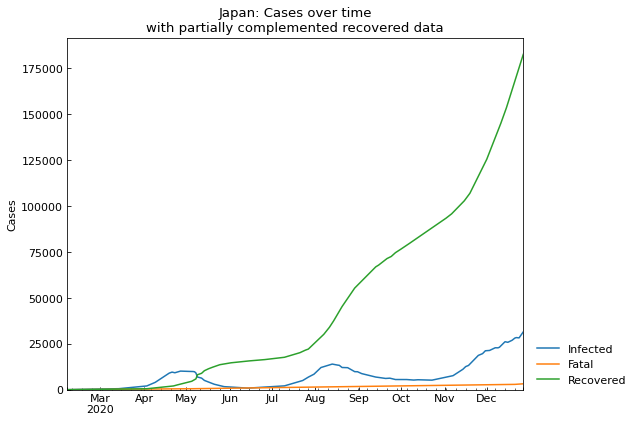

,Date,Infected,Fatal,Recovered
321,2020-12-23,28004,2994,172115
322,2020-12-24,28210,3050,174879
323,2020-12-25,29082,3105,177793
324,2020-12-26,30204,3155,180188
325,2020-12-27,31503,3213,182596


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

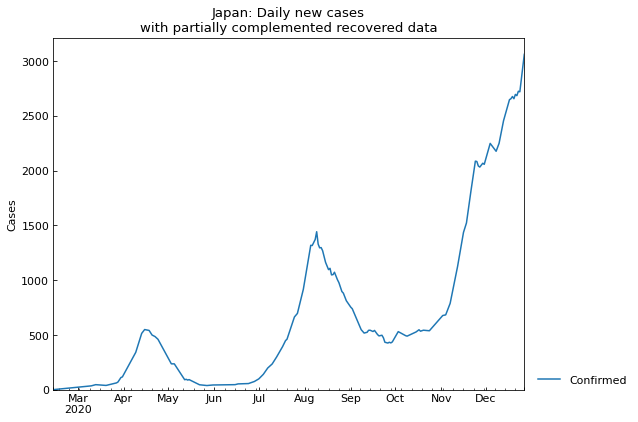

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

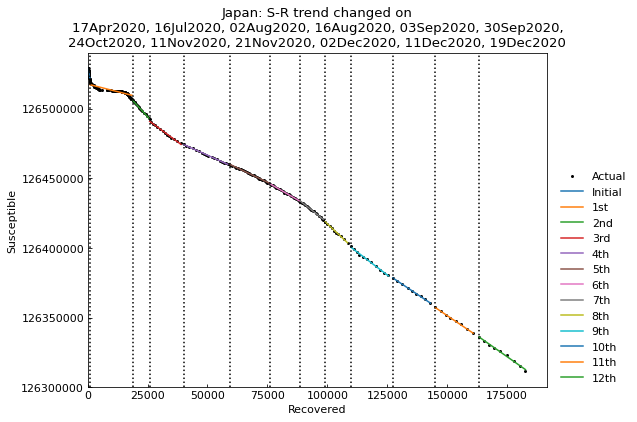

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,15Jul2020,126529100
2nd,Past,16Jul2020,01Aug2020,126529100
3rd,Past,02Aug2020,15Aug2020,126529100
4th,Past,16Aug2020,02Sep2020,126529100
5th,Past,03Sep2020,29Sep2020,126529100
6th,Past,30Sep2020,23Oct2020,126529100
7th,Past,24Oct2020,10Nov2020,126529100
8th,Past,11Nov2020,20Nov2020,126529100
9th,Past,21Nov2020,01Dec2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (17Apr2020 - 15Jul2020): finished 2626 trials in 3 min  1 sec


	 2nd phase (11Dec2020 - 18Dec2020): finished  366 trials in 0 min 10 sec

	 5th phase (02Dec2020 - 10Dec2020): finished  681 trials in 0 min 20 sec

	 6th phase (11Nov2020 - 20Nov2020): finished  952 trials in 0 min 30 sec

	 3rd phase (16Aug2020 - 02Sep2020): finished  352 trials in 0 min 10 sec

	 0th phase (02Aug2020 - 15Aug2020): finished 3534 trials in 3 min  0 sec

	10th phase (19Dec2020 - 27Dec2020): finished 3527 trials in 3 min  0 sec

	 7th phase (30Sep2020 - 23Oct2020): finished 3512 trials in 3 min  0 sec

	 8th phase (21Nov2020 - 01Dec2020): finished  624 trials in 0 min 20 sec

	 9th phase (03Sep2020 - 29Sep2020): finished 3420 trials in 3 min  0 sec

	 1st phase (24Oct2020 - 10Nov2020): finished 3450 trials in 3 min  0 sec

	11th phase (06Feb2020 - 16Apr2020): finished 3394 trials in 3 min  0 sec

	 4th phase (16Jul2020 - 01Aug2020): finished 3497 trials in 3 min  0 sec

Completed optimization. Total: 9 min 34 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/gamma [day],1/beta [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.62,0.018973,0.000151,0.020557,0.004215,288,0.019,47,9,1324,0.259382,3394,3 min 0 sec
1st,Past,17Apr2020,15Jul2020,126529100,SIR-F,0.55,0.076974,0.000128,0.006934,0.011573,288,0.077,17,28,1561,0.355588,2626,3 min 1 sec
2nd,Past,16Jul2020,01Aug2020,126529100,SIR-F,2.00,0.000585,0.000051,0.028182,0.014031,288,0.001,14,7,3954,0.025613,3497,3 min 0 sec
3rd,Past,02Aug2020,15Aug2020,126529100,SIR-F,1.51,0.000864,0.000054,0.020451,0.013461,288,0.001,14,9,3735,0.050528,3534,3 min 0 sec
4th,Past,16Aug2020,02Sep2020,126529100,SIR-F,0.77,0.001759,0.000194,0.014593,0.018789,288,0.002,10,13,1031,0.013953,352,0 min 10 sec
5th,Past,03Sep2020,29Sep2020,126529100,SIR-F,0.81,0.001162,0.000258,0.016896,0.020633,288,0.001,9,11,774,0.029102,3420,3 min 0 sec
6th,Past,30Sep2020,23Oct2020,126529100,SIR-F,0.99,0.000496,0.000208,0.021713,0.021658,288,0.000,9,9,962,0.013476,3512,3 min 0 sec
7th,Past,24Oct2020,10Nov2020,126529100,SIR-F,1.31,0.001943,0.000173,0.021455,0.016170,288,0.002,12,9,1155,0.022356,3450,3 min 0 sec
8th,Past,11Nov2020,20Nov2020,126529100,SIR-F,1.68,0.001356,0.000172,0.027581,0.016265,288,0.001,12,7,1165,0.013209,952,0 min 30 sec
9th,Past,21Nov2020,01Dec2020,126529100,SIR-F,1.35,0.000747,0.000157,0.023950,0.017517,288,0.001,11,8,1270,0.022211,624,0 min 20 sec


### Accuracy of estimation

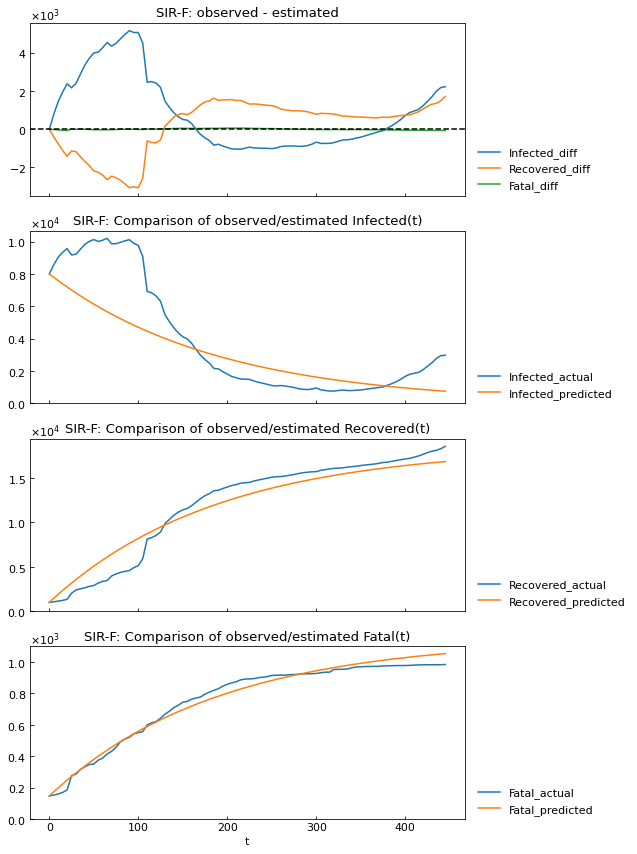

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [12]:
snl.get("Rt", phase="4th")

0.77

### Show parameter history

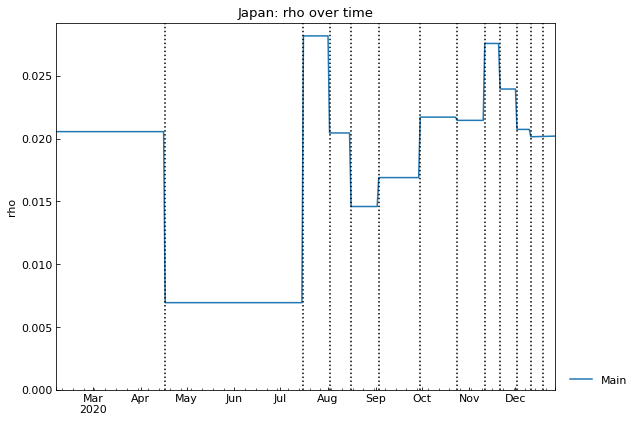

In [13]:
_ = snl.history(target="rho")

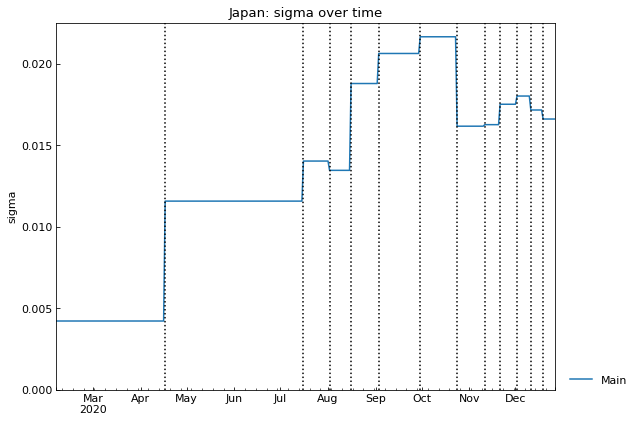

In [14]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

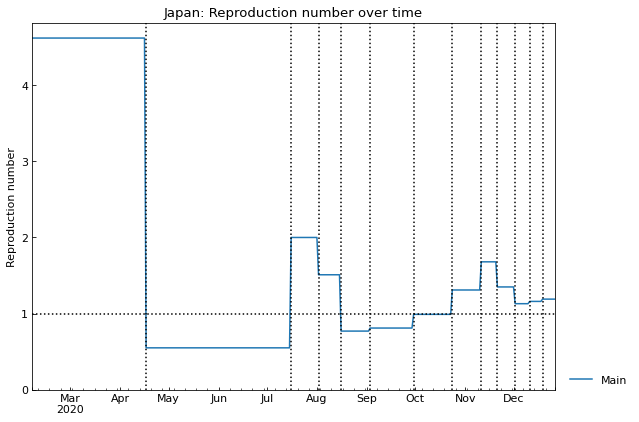

In [15]:
_ = snl.history(target="Rt")

### Simulate the number of cases

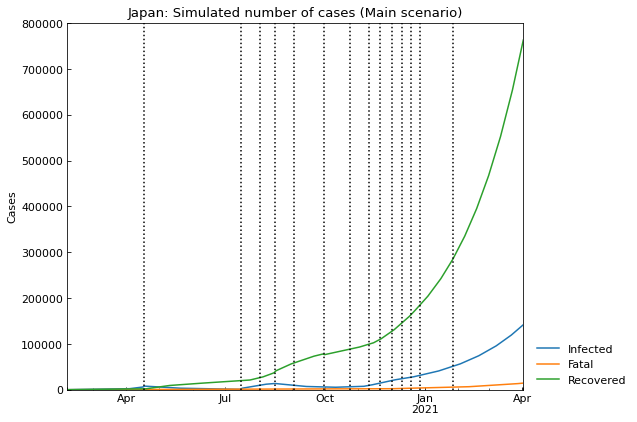

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,864228,13521,133199,717508
418,2021-03-30,877696,13736,135301,728659
419,2021-03-31,891376,13955,137435,739986
420,2021-04-01,905268,14177,139601,751490
421,2021-04-02,919377,14402,141799,763176


In [16]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [17]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.01661041462851606

In [18]:
sigma_new = sigma_current * 2
sigma_new

0.03322082925703212

In [19]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  4.62   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.55   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  2.00   
         3rd      Past  02Aug2020  15Aug2020   126529100  SIR-F  1.51   
         4th      Past  16Aug2020  02Sep2020   126529100  SIR-F  0.77   
         5th      Past  03Sep2020  29Sep2020   126529100  SIR-F  0.81   
         6th      Past  30Sep2020  23Oct2020   126529100  SIR-F  0.99   
         7th      Past  24Oct2020  10Nov2020   126529100  SIR-F  1.31   
         8th      Past  11Nov2020  20Nov2020   126529100  SIR-F  1.68   
         9th      Past  21Nov2020  01Dec2020   126529100  SIR-F  1.35   
         10th     Past  02Dec2020  10Dec2020   126529100  SIR-F  1.13   
         11th     Past  11Dec2020  18Dec2020   126529100  SIR-F  1.16   
         12th     Past  19Dec2020  27Dec2020   126529100  SIR-F  1.19   
         13th   Future  28Dec2020  26Jan2021   126529100  SIR-F  1.19   
         14th   Future  27Jan2021  01Apr2021   126529100  SIR-F  1.19   
Medicine 0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  4.62   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.55   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  2.00   
         3rd      Past  02Aug2020  15Aug2020   126529100  SIR-F  1.51   
         4th      Past  16Aug2020  02Sep2020   126529100  SIR-F  0.77   
         5th      Past  03Sep2020  29Sep2020   126529100  SIR-F  0.81   
         6th      Past  30Sep2020  23Oct2020   126529100  SIR-F  0.99   
         7th      Past  24Oct2020  10Nov2020   126529100  SIR-F  1.31   
         8th      Past  11Nov2020  20Nov2020   126529100  SIR-F  1.68   
         9th      Past  21Nov2020  01Dec2020   126529100  SIR-F  1.35   
         10th     Past  02Dec2020  10Dec2020   126529100  SIR-F  1.13   
         11th     Past  11Dec2020  18Dec2020   126529100  SIR-F  1.16   
         12th     Past  19Dec2020  27Dec2020   126529100  SIR-F  1.19   
         13th   Future  28Dec2020  26Jan2021   126529100  SIR-F  1.19   
         14th   Future  27Jan2021  01Apr2021   126529100  SIR-F  0.60   

                   theta     kappa       rho     sigma  tau  alpha1 [-]  \
Scenario Phase                                                            
Main     0th    0.018973  0.000151  0.020557  0.004215  288       0.019   
         1st    0.076974  0.000128  0.006934  0.011573  288       0.077   
         2nd    0.000585  0.000051  0.028182  0.014031  288       0.001   
         3rd    0.000864  0.000054  0.020451  0.013461  288       0.001   
         4th    0.001759  0.000194  0.014593  0.018789  288       0.002   
         5th    0.001162  0.000258  0.016896  0.020633  288       0.001   
         6th    0.000496  0.000208  0.021713  0.021658  288       0.000   
         7th    0.001943  0.000173  0.021455  0.016170  288       0.002   
         8th    0.001356  0.000172  0.027581  0.016265  288       0.001   
         9th    0.000747  0.000157  0.023950  0.017517  288       0.001   
         10th   0.000121  0.000294  0.020733  0.018021  288       0.000   
         11th   0.000256  0.000257  0.020146  0.017164  288       0.000   
         12th   0.000220  0.000316  0.020201  0.016610  288       0.000   
         13th   0.000220  0.000316  0.020201  0.016610  288       0.000   
         14th   0.000220  0.000316  0.020201  0.016610  288       0.000   
Medicine 0th    0.018973  0.000151  0.020557  0.004215  288       0.019   
         1st    0.076974  0.000128  0.006934  0.011573  288       0.077   
         2nd    0.000585  0.000051  0.028182  0.014031  288       0.001   
         3rd    0.000864  0.000054  0.020451  0.013461  288       0.001   
         4th    0.001759  0.000194  0.014593  0.018789  288       0.002   
         5th    0.001162  0.000

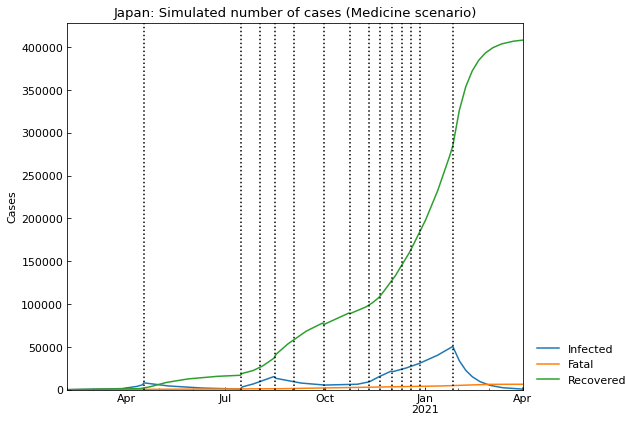

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,414936,6357,850,407729
418,2021-03-30,415018,6358,795,407865
419,2021-03-31,415096,6360,744,407992
420,2021-04-01,415168,6361,696,408111
421,2021-04-02,415235,6362,651,408222


In [20]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [21]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,14th_Rt
Main,141799,02Apr2021,919377,141799,14402,1.19
Medicine,50482,27Jan2021,415235,651,6362,0.60


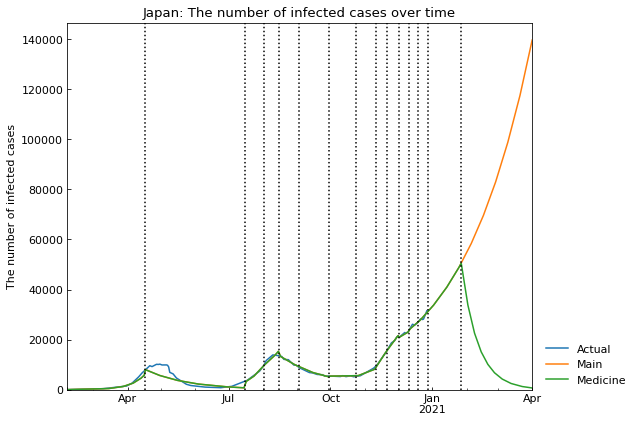

In [22]:
_ = snl.history(target="Infected")

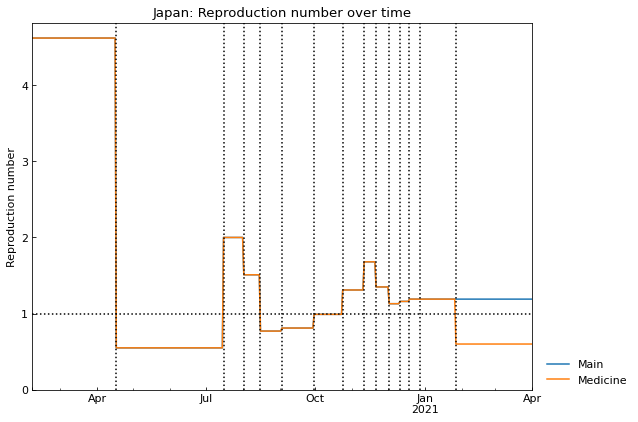

In [23]:
_ = snl.history(target="Rt")

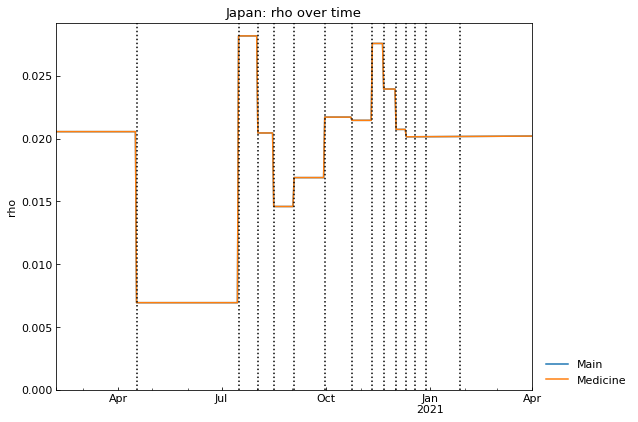

In [24]:
_ = snl.history(target="rho")

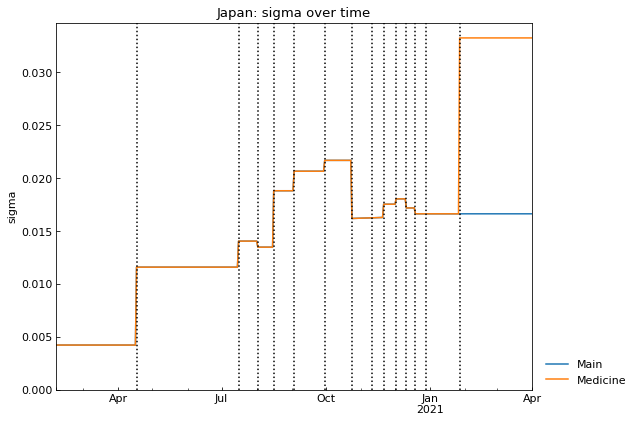

In [25]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 18Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

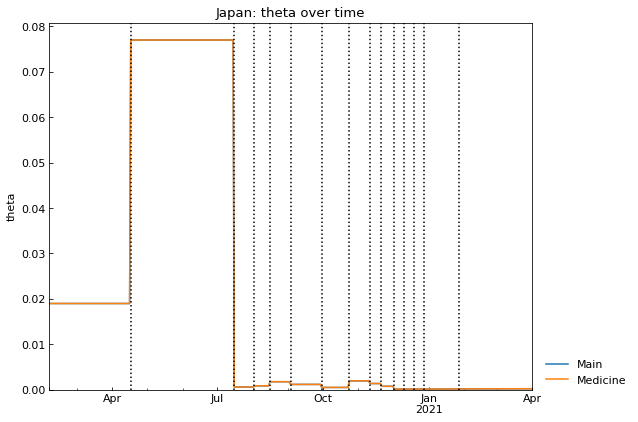

In [26]:
_ = snl.history(target="theta")

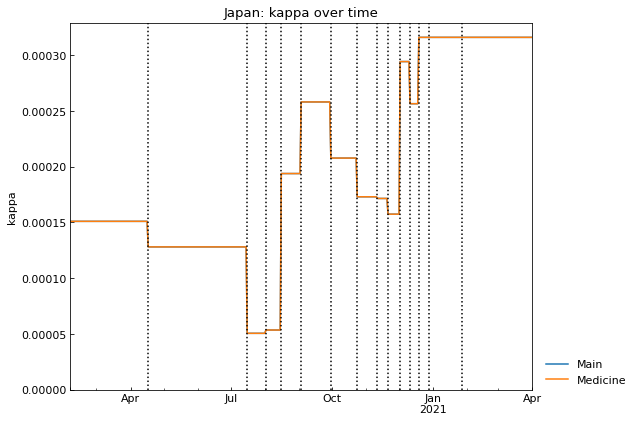

In [27]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

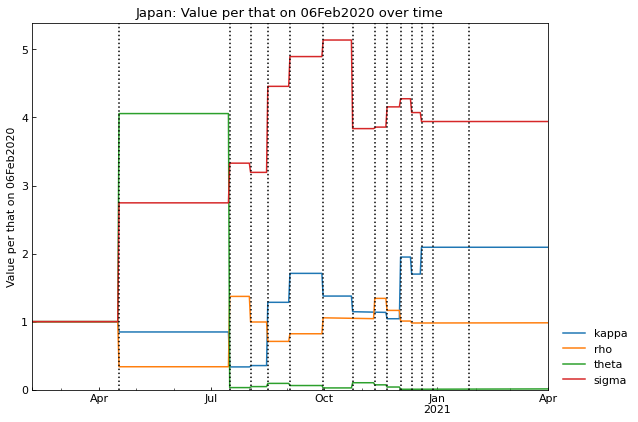

In [28]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [29]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (17Apr2020 - 15Jul2020): finished 2557 trials in 3 min  2 sec


	 2nd phase (11Dec2020 - 18Dec2020): finished  332 trials in 0 min 10 sec

	 5th phase (02Dec2020 - 10Dec2020): finished  637 trials in 0 min 20 sec

	 6th phase (11Nov2020 - 20Nov2020): finished  846 trials in 0 min 30 sec

	 3rd phase (16Aug2020 - 02Sep2020): finished  318 trials in 0 min 10 sec

	 0th phase (02Aug2020 - 15Aug2020): finished 3292 trials in 3 min  0 sec

	10th phase (19Dec2020 - 27Dec2020): finished 3313 trials in 3 min  0 sec

	 7th phase (30Sep2020 - 23Oct2020): finished 3270 trials in 3 min  0 sec

	 8th phase (21Nov2020 - 01Dec2020): finished  554 trials in 0 min 20 sec

	 9th phase (03Sep2020 - 29Sep2020): finished 3213 trials in 3 min  0 sec

	 1st phase (24Oct2020 - 10Nov2020): finished 3262 trials in 3 min  0 sec

	11th phase (06Feb2020 - 16Apr2020): finished 3217 trials in 3 min  0 sec

	 4th phase (16Jul2020 - 01Aug2020): finished 3334 trials in 3 min  0 sec

Completed optimization. Total: 9 min 35 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (16Aug2020 - 27Dec2020): finished 10404 trials in 3 min  0 sec

Completed optimization. Total: 3 min  0 sec


In [30]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.62  0.018973  0.000151   
              1st    17Apr2020  15Jul2020  SIR-F  0.55  0.076974  0.000128   
              2nd    16Jul2020  01Aug2020  SIR-F  2.00  0.000585  0.000051   
              3rd    02Aug2020  15Aug2020  SIR-F  1.51  0.000864  0.000054   
              4th    16Aug2020  02Sep2020  SIR-F  0.77  0.001759  0.000194   
              5th    03Sep2020  29Sep2020  SIR-F  0.81  0.001162  0.000258   
              6th    30Sep2020  23Oct2020  SIR-F  0.99  0.000496  0.000208   
              7th    24Oct2020  10Nov2020  SIR-F  1.31  0.001943  0.000173   
              8th    11Nov2020  20Nov2020  SIR-F  1.68  0.001356  0.000172   
              9th    21Nov2020  01Dec2020  SIR-F  1.35  0.000747  0.000157   
              10th   02Dec2020  10Dec2020  SIR-F  1.13  0.000121  0.000294   
              11th   11Dec2020  18Dec2020  SIR-F  1.16  0.000256  0.000257   
              12th   19Dec2020  27Dec2020  SIR-F  1.19  0.000220  0.000316   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.62  0.018973  0.000151   
              1st    17Apr2020  15Jul2020  SIR-F  0.55  0.076974  0.000128   
              2nd    16Jul2020  01Aug2020  SIR-F  2.00  0.000585  0.000051   
              3rd    02Aug2020  15Aug2020  SIR-F  1.51  0.000864  0.000054   
              4th    16Aug2020  27Dec2020  SIR-F  1.51  0.000864  0.000054   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.020557  0.004215  0.259382    3217  3 min  0 sec  
              1st    0.006934  0.011573  0.355588    2557  3 min  2 sec  
              2nd    0.028182  0.014031  0.025613    3334  3 min  0 sec  
              3rd    0.020451  0.013461  0.050528    3292  3 min  0 sec  
              4th    0.014593  0.018789  0.013953     318  0 min 10 sec  
              5th    0.016896  0.020633  0.029102    3213  3 min  0 sec  
              6th    0.021713  0.021658  0.013476    3270  3 min  0 sec  
              7th    0.021455  0.016170  0.022356    3262  3 min  0 sec  
              8th    0.027581  0.016265  0.013209     846  0 min 30 sec  
              9th    0.023950  0.017517  0.022211     554  0 min 20 sec  
              10th   0.020733  0.018021  0.009690     637  0 min 20 sec  
              11th   0.020146  0.017164  0.012531     332  0 min 10 sec  
              12th   0.020201  0.016610  0.011156    3313  3 min  0 sec  
Retrospective 0th    0.020557  0.004215  0.259382    3217  3 min  0 sec  
              1st    0.006934  0.011573  0.355588    2557  3 min  2 sec  
              2nd    0.028182  0.014031  0.025613    3334  3 min  0 sec  
              3rd    0.020451  0.013461  0.050528    3292  3 min  0 sec  
              4th    0.020451  0.013461  1.861255   10404  3 min  0 sec

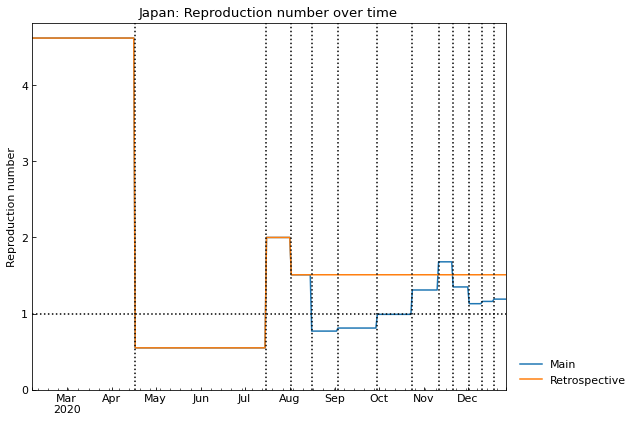

In [31]:
# History of reproduction number
_ = snl_retro.history("Rt")

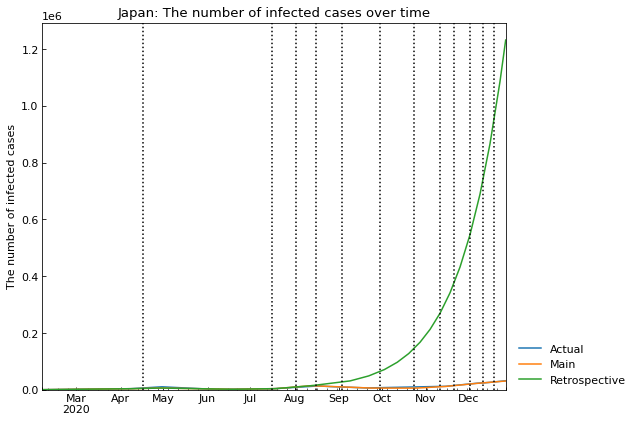

In [32]:
# History of Infected
_ = snl_retro.history("Infected")

In [33]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 28Dec2020,Infected on 28Dec2020,Fatal on 28Dec2020,4th_Rt,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,31113,28Dec2020,219309,31113,3246,0.77,0.81,0.99,1.31,1.68,1.35,1.13,1.16,1.19
Retrospective,1270719,28Dec2020,3889882,1270719,14599,1.51,-,-,-,-,-,-,-,-
